# Imports and Installations

In [81]:
import sys

!{sys.executable} -m pip install xgboost


In [82]:
import numpy as np #for handling arrays 
import pandas as pd #for handling dataframes 
# for building models 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
# for hyperparameter tuning 
from sklearn.model_selection import train_test_split, GridSearchCV
# for model evaluation 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
# for visualzing results 
import matplotlib.pyplot as plt 
# to interact with hardware and save the final model 
import os
import joblib
# to display dataframes 
from IPython.display import display
# use the style available in seaborn library 
plt.style.use('seaborn')
import warnings
warnings.simplefilter(action='ignore')

# Constants

In [83]:
# create some constants 
RESULTS_SAVE_PATH = 'Results/'
MODEL_SAVE_PATH = 'Objects/Models/'
EVALUATION_FIGSIZE = (16,6)
EVALUATION_NROWS = 1
EVALUATION_NCOLS = 2
STATES = ['TX', 'CA', 'VA', 'NC', 'CO', 'FL', 'MA', 'MD']
TEST_SIZE = 0.3
RANDOM_STATE = 42
PREPROCESSED_FILE_PATH = 'preprocessed/'

In [84]:
# Fetch the data and store in the dictionary 
df_dict = dict(zip(STATES, [pd.read_csv(os.path.join(PREPROCESSED_FILE_PATH,f'{state}.csv')) for state in STATES]))


In [85]:
def summarise_data(df):
    print("\nOverview")
    display(df.head())
    print("\nSummary")
    display(df.describe(include= "all"))
    print("\nNull Values")
    display(df.isnull().sum()/len(df))
    print("\nShape")
    display(df.shape)

In [86]:
print(df_dict['TX'].tail())

      category_0  category_1  bathrooms  bedrooms  fee_0  fee_1  pets_allowed  \
9200           0           1        2.0       2.0      0      1             0   
9201           0           1        1.0       1.0      0      1             0   
9202           0           1        1.0       2.0      0      1             0   
9203           0           1        2.0       2.0      0      1             0   
9204           0           1        1.0       1.0      0      1             0   

       price  square_feet  cityname  ...  with_woodfloors_0  \
9200  1282.0         1207        80  ...                  0   
9201   685.0          625        80  ...                  0   
9202   870.0          798        80  ...                  0   
9203   945.0         1000        80  ...                  0   
9204   780.0          605        80  ...                  1   

      with_woodfloors_1  with_patio_0  with_patio_1  with_clubhouse_0  \
9200                  1             0             1          

# Preparing data for model

In [87]:
#store X and y for each state in dictionary
X_dict = dict(zip(STATES,[df.drop(['price'], axis = 1) for df in df_dict.values()]))
y_dict = dict(zip(STATES,[df['price'] for df in df_dict.values()]))

In [88]:
# Create dictionaries for X_train, y_train, X_test and y_test 
X_train_dict = {}
X_test_dict = {}
y_train_dict = {}
y_test_dict = {}

for state in STATES:
    # Subset X and y for each state
    X = X_dict[state]
    y = y_dict[state]
    # Perform train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=TEST_SIZE, random_state=RANDOM_STATE)
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    # Store values in the dictionary for training models
    X_train_dict[state] = X_train
    X_test_dict[state] = X_test
    y_train_dict[state] = y_train
    y_test_dict[state] = y_test
    

In [89]:
# create a helper function
def summarize_model(model):
    model_r2_train_dict = {} #create a dictionary for r2 score of train set
    model_r2_test_dict = {} #create a dictionary for r2 score of test set
    model_mae_train_dict = {} #create a dictionary for mae of train set 
    model_mae_test_dict = {} #create a dictionary for mae of test set
    model_mse_train_dict = {}
    model_mse_test_dict = {}
    model_dict = {} #create a dictionary of models 
    for state in STATES:#loop through states
        model.fit(X_train_dict[state],y_train_dict[state]) #fit the model 
        model_dict[state] = model #store the model for that state in model dict
        model_train_preds = model.predict(X_train_dict[state]) #predict for train set 
        model_test_preds = model.predict(X_test_dict[state]) #predict for test set 
        model_r2_train_dict[state] = r2_score(y_true=y_train_dict[state], y_pred=model_train_preds) #calculate r2 for train set 
        model_r2_test_dict[state] = r2_score(y_true=y_test_dict[state], y_pred=model_test_preds) #calculate r2 for test set 
        model_mae_train_dict[state] = mean_absolute_error(y_true=y_train_dict[state],y_pred=model_train_preds) #calcaulte mae for train set
        model_mae_test_dict[state] = mean_absolute_error(y_true=y_test_dict[state], y_pred=model_test_preds) #calculate mae for test set 
        
    #store metrics in a dictionary
    metrics_dict = {
        'train r2':model_r2_train_dict,
        'test r2':model_r2_test_dict,
        'train mae':model_mae_train_dict,
        'test mae':model_mae_test_dict,
        
    }
    display(pd.DataFrame(metrics_dict))
    return model_dict, metrics_dict #return model and metrics 
        
        
        

In [90]:
# Linear Regression 
lr_dict, lr_metrics = summarize_model(LinearRegression())

,train r2,test r2,train mae,test mae
TX,0.410734,0.379046,199.281698,202.966332
CA,0.203755,0.211241,549.686860,539.739327
VA,0.322708,0.325218,303.562634,305.296695
NC,0.260837,0.264381,184.478514,187.657865
CO,0.402230,0.394350,216.176644,213.778480
FL,0.292227,0.319638,233.220868,243.209582
MA,0.299246,0.302038,406.644814,396.082517
MD,0.359599,0.351001,220.423938,230.624987


In [91]:
dt_dict, dt_metrics = summarize_model(DecisionTreeRegressor())

,train r2,test r2,train mae,test mae
TX,0.985711,0.312428,12.994905,188.958990
CA,0.993370,0.463080,19.160638,363.637724
VA,0.993679,0.664727,15.426144,166.327950
NC,0.985776,0.257382,12.079424,162.550373
CO,0.978943,0.466674,21.527448,166.272034
FL,0.992399,0.186681,11.694131,235.978137
MA,0.992989,0.376025,16.732065,331.246943
MD,0.990854,0.556340,14.925932,159.019199


In [92]:
rf_dict, rf_metrics = summarize_model(RandomForestRegressor())

,train r2,test r2,train mae,test mae
TX,0.935205,0.592651,60.038813,151.194357
CA,0.955058,0.689727,113.170591,293.560549
VA,0.965148,0.793393,61.273208,142.309784
NC,0.928725,0.557498,52.875202,132.956344
CO,0.939422,0.679044,61.929362,137.343799
FL,0.927574,0.562560,70.388878,179.944892
MA,0.946769,0.645934,105.002197,266.165436
MD,0.952903,0.691639,54.418962,139.441630


In [93]:
# Adaboost Regression
adaboost_dict, adaboost_metrics = summarize_model(AdaBoostRegressor())

,train r2,test r2,train mae,test mae
TX,0.371595,0.356936,217.129142,218.912002
CA,0.242392,0.240207,549.711223,543.758493
VA,0.374646,0.351858,304.703038,312.405042
NC,0.257506,0.231893,195.220349,202.919719
CO,0.386450,0.338504,234.997596,235.445568
FL,0.234777,0.234259,258.711944,273.334883
MA,0.405104,0.370087,386.622662,388.470839
MD,0.339517,0.343671,235.779561,241.083988


In [94]:
# Gradient boosting regression 
gb_dict, gb_metrics = summarize_model(GradientBoostingRegressor())

,train r2,test r2,train mae,test mae
TX,0.570750,0.525169,166.781606,176.074628
CA,0.602814,0.567373,371.761985,384.221245
VA,0.698262,0.672624,196.311072,204.462740
NC,0.532100,0.485607,145.316969,156.272680
CO,0.631054,0.579410,168.651181,177.220879
FL,0.550328,0.511978,183.282442,203.594503
MA,0.629816,0.576276,290.691490,309.054505
MD,0.657151,0.611183,159.656073,174.066574


In [95]:
# XGBoost Regression 
xgb_dict, xgb_metrics = summarize_model(XGBRegressor(objective='reg:squarederror'))

,train r2,test r2,train mae,test mae
TX,0.817281,0.615767,102.453844,152.976936
CA,0.871452,0.679357,195.977884,308.591073
VA,0.927780,0.803232,90.566734,148.943172
NC,0.848977,0.569860,75.540890,135.161646
CO,0.874565,0.673781,88.885465,143.956347
FL,0.892054,0.590756,83.392826,172.171798
MA,0.940830,0.731459,107.517168,232.224779
MD,0.937853,0.737956,63.125082,130.746956


In [96]:
# create dictionaries for visualization 
model_dict = {
    
    'DT':dt_dict,
    'RF':rf_dict,
    'ADA':adaboost_dict,
    'GB':gb_dict,
    'XGB':xgb_dict
}
model_metrics = {
    
    'DT':dt_metrics,
    'RF':rf_metrics,
    'ADA':adaboost_metrics,
    'GB':gb_metrics,
    'XGB':xgb_metrics
}

In [97]:
# Create dictionaries for metrics for all models 
train_r2 = {}
test_r2 = {}
train_mae = {}
test_mae = {}

for model, metrics_dict in model_metrics.items():
    train_r2[model] = metrics_dict['train r2']
    test_r2[model] = metrics_dict['test r2']
    train_mae[model] = metrics_dict['train mae']
    test_mae[model] = metrics_dict['test mae']

In [98]:
# Convert them to dataframes 
train_r2 = pd.DataFrame(train_r2)
test_r2 = pd.DataFrame(test_r2)
train_mae = pd.DataFrame(train_mae)
test_mae = pd.DataFrame(test_mae)

In [99]:
# Change the column names for identification 
train_r2.columns = [col+'_train_r2' for col in train_r2.columns]
test_r2.columns = [col+'_test_r2' for col in test_r2.columns] 
train_mae.columns = [col+'_train_mae' for col in train_mae.columns]
test_mae.columns = [col+'_test_mae' for col in test_mae.columns]

In [100]:
# Create dataframe for plotting r2 score 
plot_r2 = pd.DataFrame()
for c1, c2 in zip(train_r2.columns, test_r2.columns):
    plot_r2[c1] = train_r2[c1]
    plot_r2[c2] = test_r2[c2]

In [101]:
# create dataframe for plotting mae 
plot_mae = pd.DataFrame()
for c1,c2 in zip(train_mae.columns, test_mae.columns):
    plot_mae[c1] = train_mae[c1]
    plot_mae[c2] = test_mae[c2]

In [102]:
# transpose the dataframes for easy plotting 
plot_r2 = plot_r2.T
plot_mae = plot_mae.T

In [103]:
# Reshape states to plot better 
states_plot = np.array(STATES).reshape(4,2)

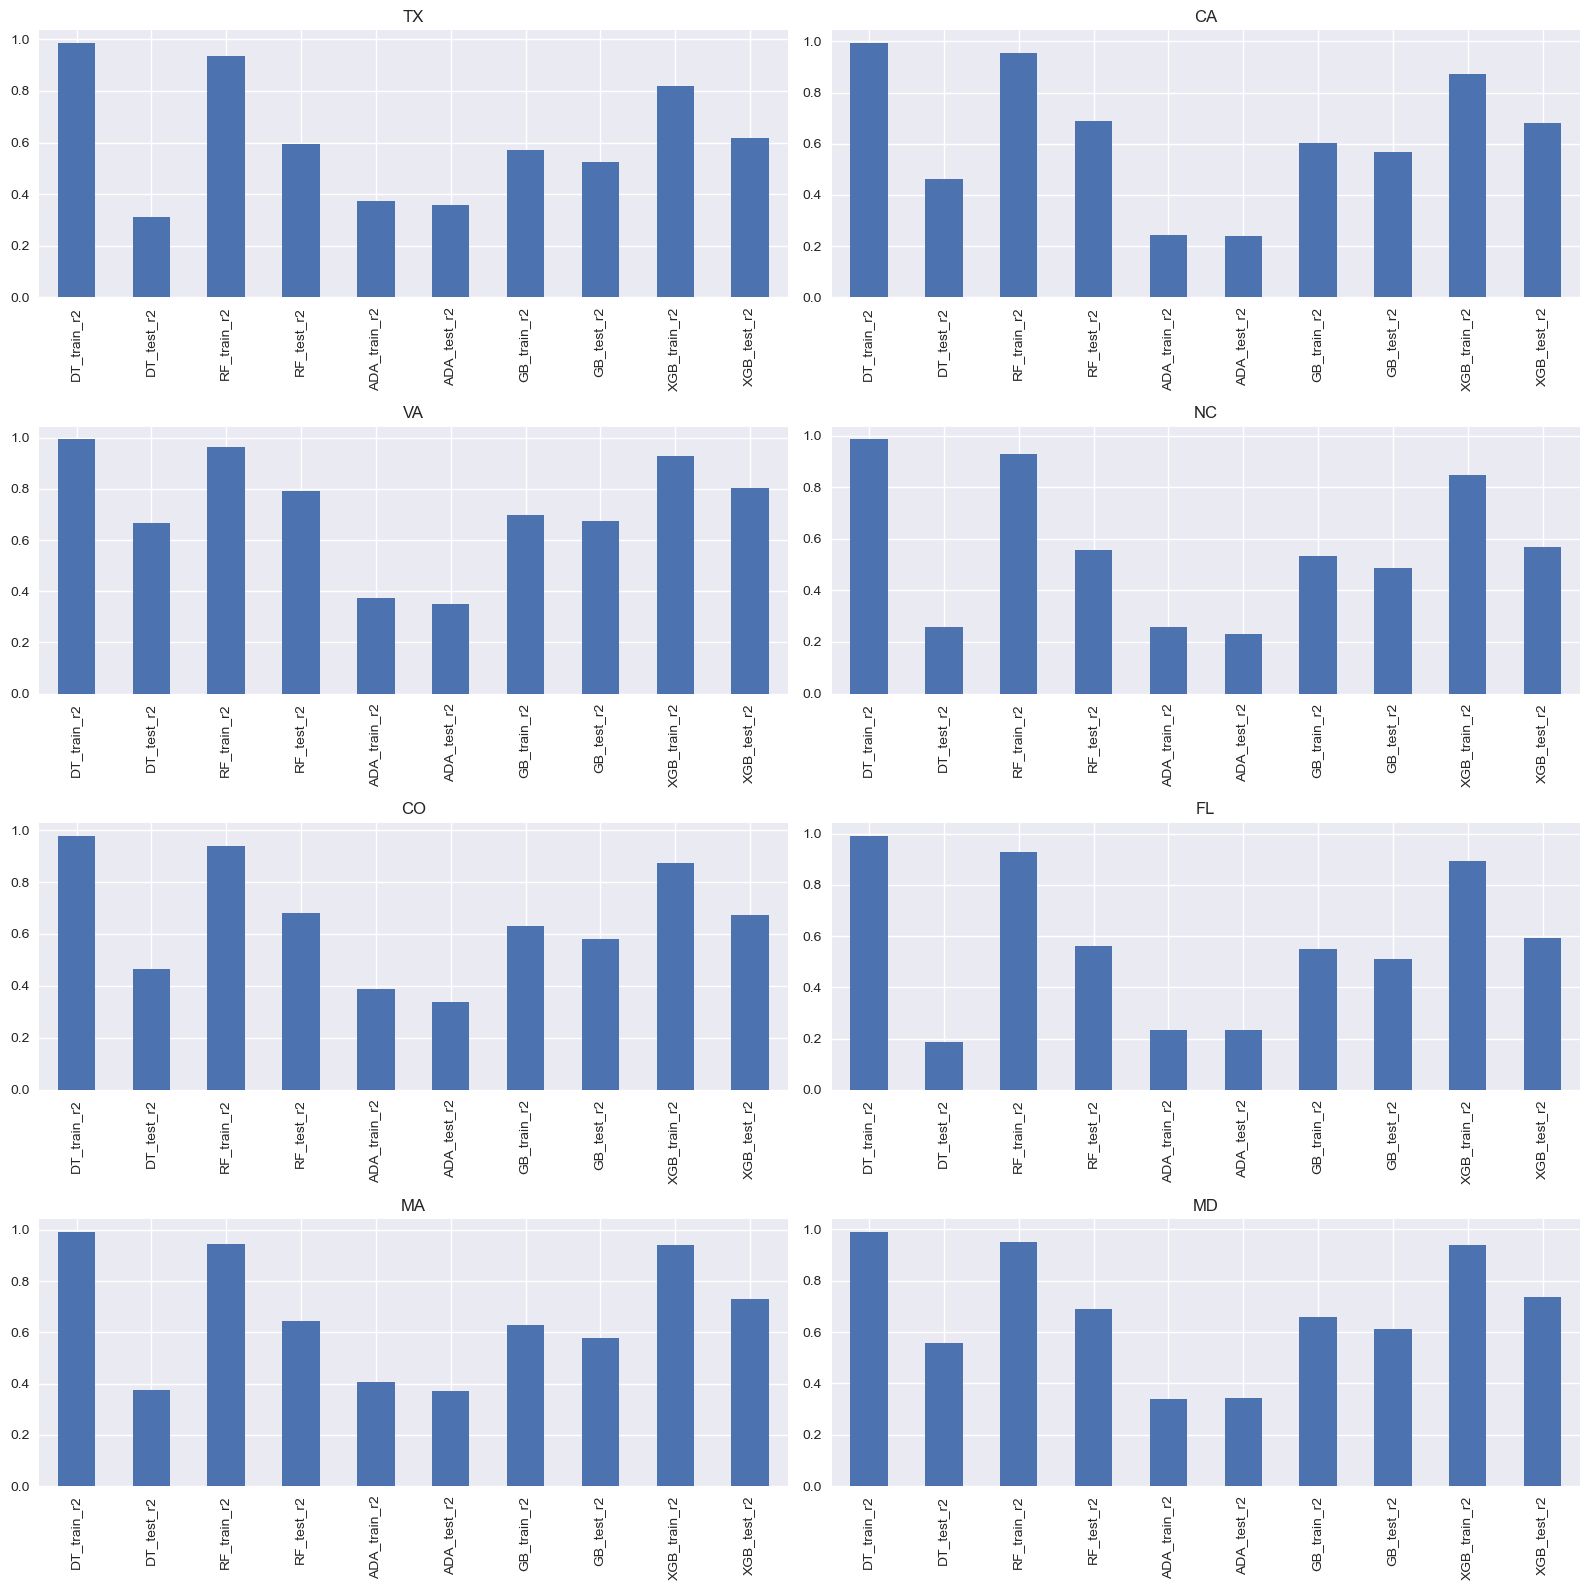

In [104]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create a 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_r2[states_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column  
        ax[i,j].set_title(states_plot[i,j]) #set title 
plt.tight_layout() #tight layout for avoiding overlap 
if not os.path.exists(RESULTS_SAVE_PATH): #check if path exists 
    os.makedirs(RESULTS_SAVE_PATH) #if not, create the path 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_models_r2.png')) #save the results 
plt.show() #show the plot 

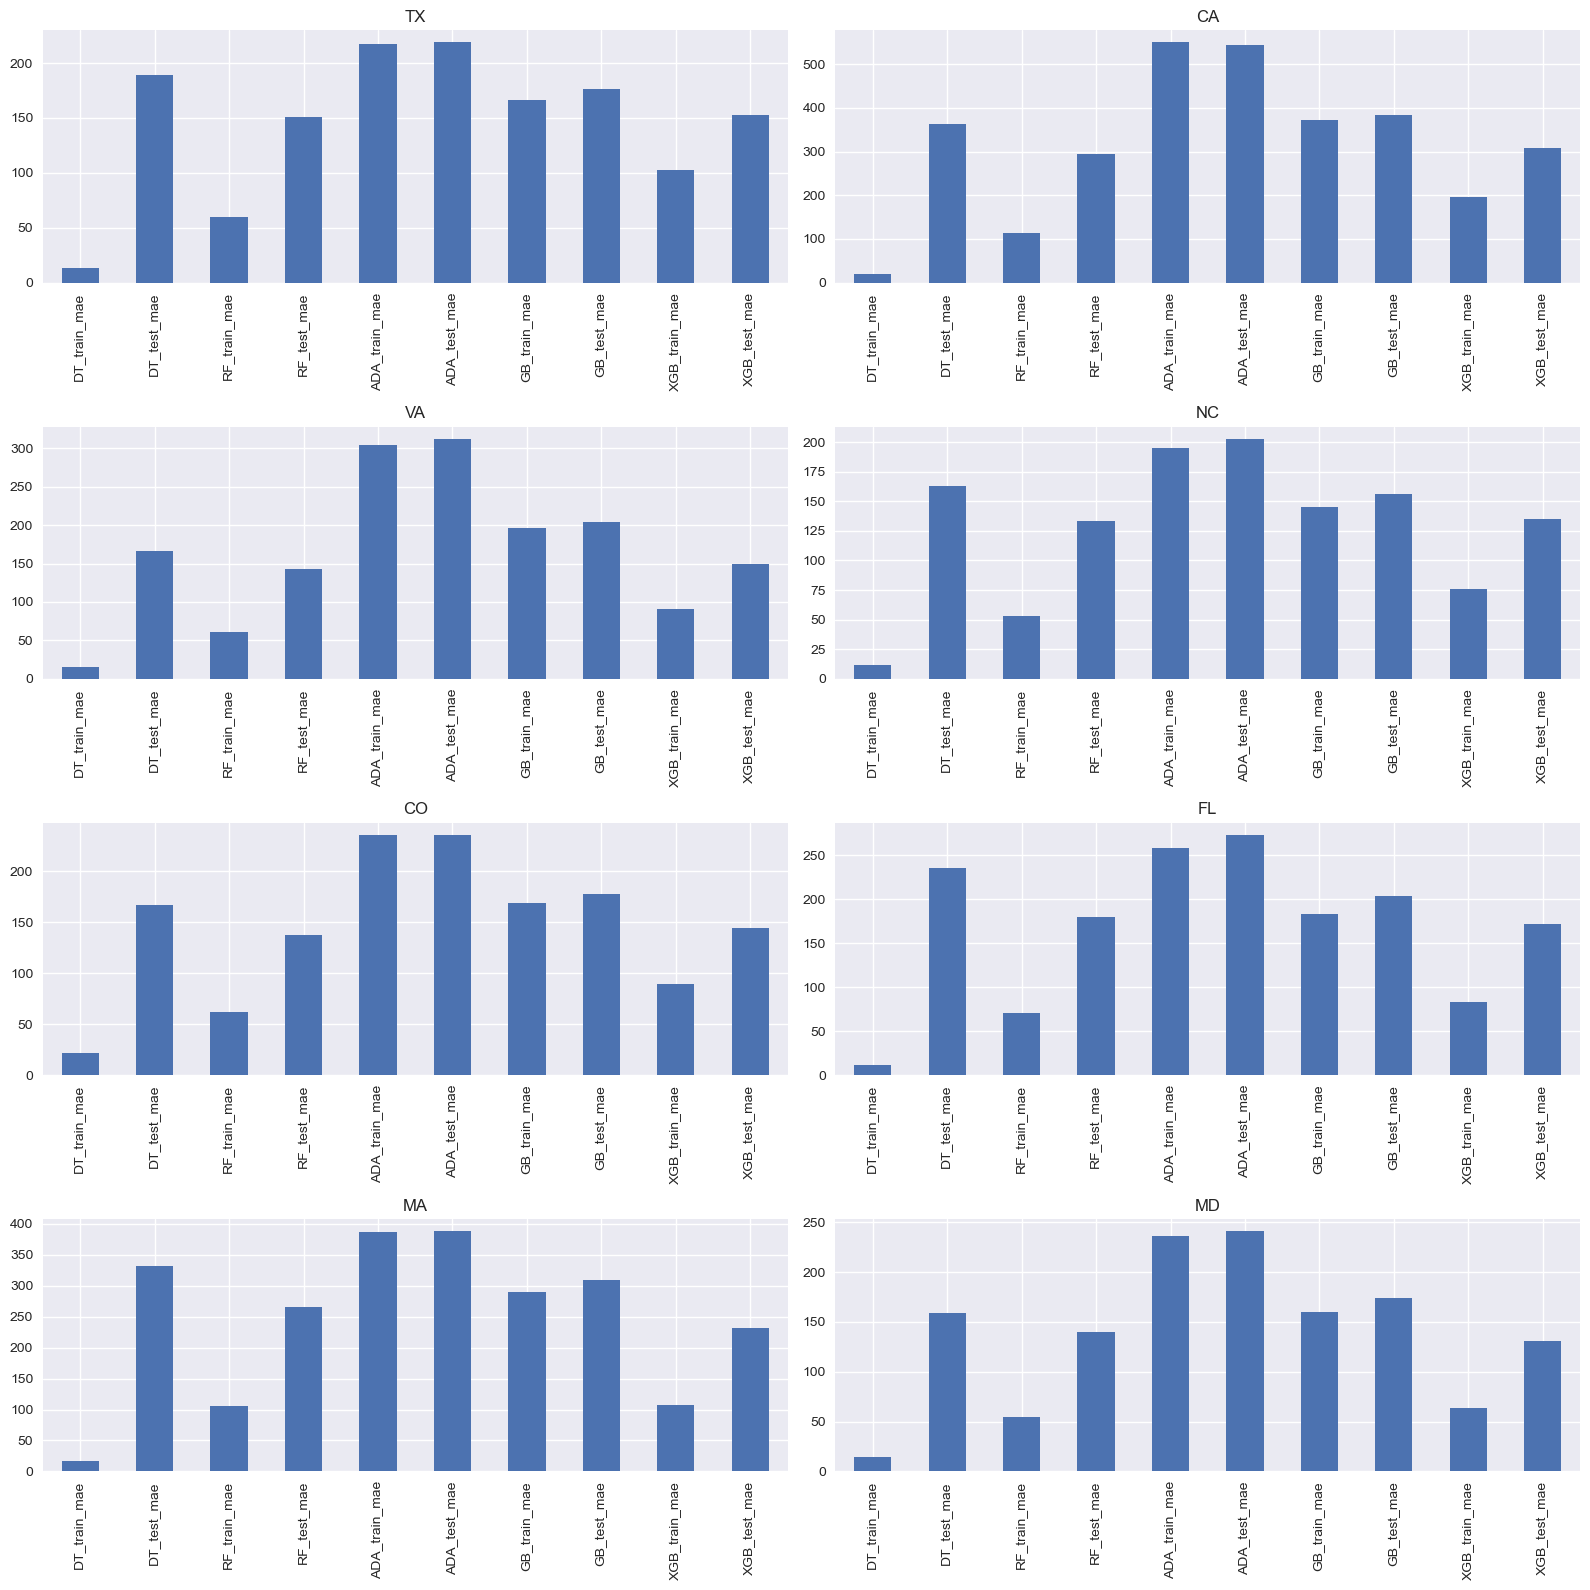

In [105]:
fig, ax = plt.subplots(figsize=(16,16),nrows=4,ncols=2) #create 4*2 figure 
for i in range(4): #loop through rows 
    for j in range(2): #loop through columns 
        plot_mae[states_plot[i,j]].plot(kind='bar',ax=ax[i,j]) #plot the column 
        ax[i,j].set_title(states_plot[i,j]) #set the title 
plt.tight_layout() #tight layout to avoud overlap 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'all_models_mae.png')) #save the figure 
plt.show() #show the figure 

In [106]:
# hyperparameter tuning 
param_tuning = {
        'learning_rate': [0.00001,0.0001,0.001,0.01,0.1,1],
        'max_depth': [1,2,3,4,5,6,7,8,9,10,11],
        'n_estimators' : [50,100,200,300,400,500,600,700,800,900,1000],
    }



In [107]:
# perform cross validation
xgb_validated_dict = {} #create a dictionary for validated xgboost model 
for state, model in xgb_dict.items(): #loop though  existing xgboost model 
    xgb_validated = GridSearchCV(model, param_tuning, cv=10, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error') #perform cross validation
    xgb_validated.fit(X_train_dict[state], y_train_dict[state]) #fit the validated model 
    xgb_validated_dict[state] = xgb_validated #save the model in the dictionary 

Fitting 10 folds for each of 726 candidates, totalling 7260 fits
Fitting 10 folds for each of 726 candidates, totalling 7260 fits
Fitting 10 folds for each of 726 candidates, totalling 7260 fits
Fitting 10 folds for each of 726 candidates, totalling 7260 fits
Fitting 10 folds for each of 726 candidates, totalling 7260 fits
Fitting 10 folds for each of 726 candidates, totalling 7260 fits
Fitting 10 folds for each of 726 candidates, totalling 7260 fits
Fitting 10 folds for each of 726 candidates, totalling 7260 fits


In [108]:
# create a dictionary for metrics 
xgb_validated_metrics = {}
train_r2_dict = {}
test_r2_dict = {}
train_mae_dict = {}
test_mae_dict = {}
for state, model in xgb_validated_dict.items(): #loop through validated xgboost models 
    train_preds = model.predict(X_train_dict[state]) #predict on train set 
    test_preds = model.predict(X_test_dict[state]) #predict on test set 
    train_r2 = r2_score(y_true=y_train_dict[state],y_pred=train_preds) #calculate r2 on train set 
    test_r2 = r2_score(y_true=y_test_dict[state],y_pred=test_preds) #calculate r2 on test set 
    train_mae = mean_absolute_error(y_true=y_train_dict[state], y_pred=train_preds) #calculate mae on train set 
    test_mae = mean_absolute_error(y_true=y_test_dict[state],y_pred=test_preds) #calculate mae on test set 
    # store metrics in respective dictionaries 
    train_r2_dict[state] = train_r2 
    test_r2_dict[state] = test_r2
    train_mae_dict[state] = train_mae
    test_mae_dict[state] = test_mae
# create dictionary for storing metrics 
xgb_validated_metrics = {
    'train r2':train_r2_dict,
    'test r2':test_r2_dict,
    'train mae': train_mae_dict,
    'test mae':test_mae_dict
}

In [109]:
# convert metrics of xgboost and validated model to dataframe 
xgb_metrics_df = pd.DataFrame(xgb_metrics)
xgb_validated_metrics_df = pd.DataFrame(xgb_validated_metrics)

In [110]:
xgb_metrics_df

,train r2,test r2,train mae,test mae
TX,0.817281,0.615767,102.453844,152.976936
CA,0.871452,0.679357,195.977884,308.591073
VA,0.927780,0.803232,90.566734,148.943172
NC,0.848977,0.569860,75.540890,135.161646
CO,0.874565,0.673781,88.885465,143.956347
FL,0.892054,0.590756,83.392826,172.171798
MA,0.940830,0.731459,107.517168,232.224779
MD,0.937853,0.737956,63.125082,130.746956


In [111]:
xgb_validated_metrics_df

,train r2,test r2,train mae,test mae
TX,0.831489,0.620276,97.779945,151.540535
CA,0.902391,0.683472,166.575326,304.800874
VA,0.965470,0.806849,60.186580,141.953439
NC,0.852076,0.578161,74.272838,132.856389
CO,0.912454,0.694541,71.352615,136.550622
FL,0.845653,0.604074,101.652337,172.770237
MA,0.910486,0.763536,134.823578,221.414001
MD,0.961518,0.735001,48.830963,129.735446


In [112]:
# rename columns for easy interpretation 
xgb_metrics_df.columns = [col + '_xgb' for col in xgb_metrics_df.columns]
xgb_validated_metrics_df.columns = [col + '_xgb_val' for col in xgb_validated_metrics_df.columns]

In [113]:
# create a final metrics dataframe for plotting 
final_metrics_df = pd.DataFrame()
for c1, c2 in zip(xgb_metrics_df.columns, xgb_validated_metrics_df.columns):
    final_metrics_df[c1] = xgb_metrics_df[c1]
    final_metrics_df[c2] = xgb_validated_metrics_df[c2]

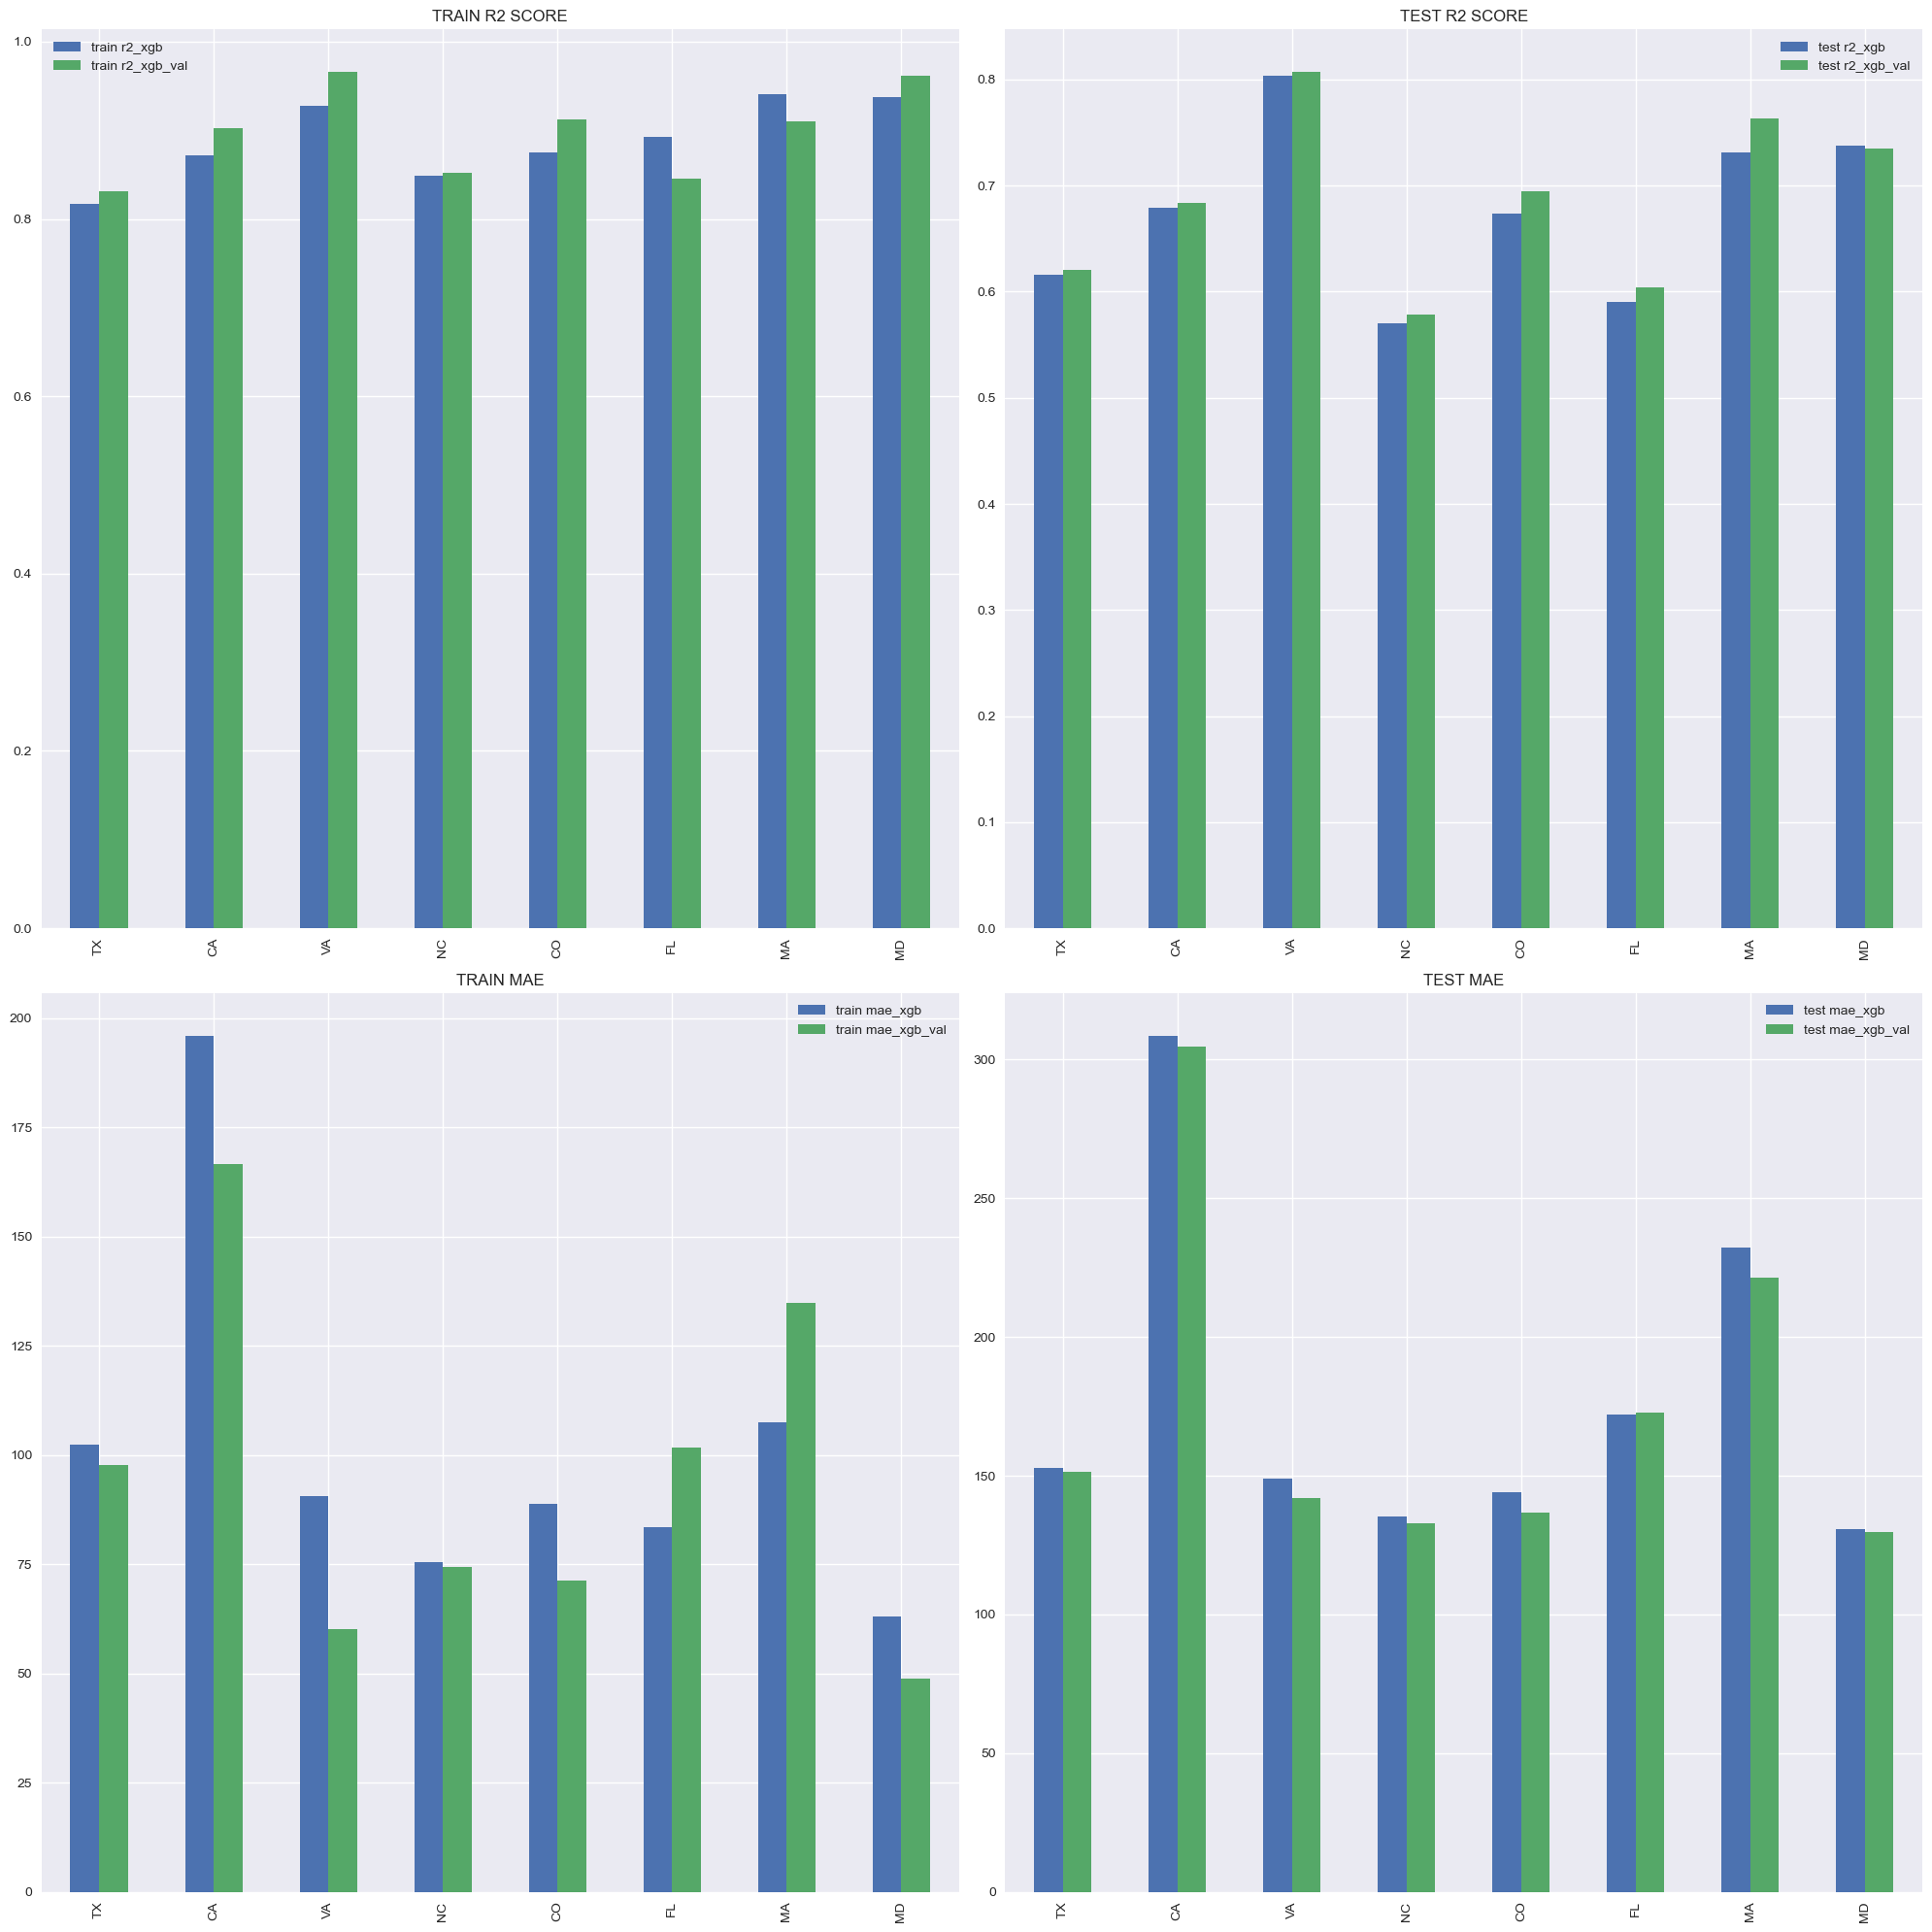

In [114]:
fig, ax = plt.subplots(figsize=(20,20),nrows=2, ncols=2) #create a 2*2 figure 
final_metrics_df[['train r2_xgb', 'train r2_xgb_val']].plot(kind='bar',ax=ax[0,0],title='TRAIN R2 SCORE') #plot train r2 for both models 
final_metrics_df[['test r2_xgb', 'test r2_xgb_val']].plot(kind='bar',ax=ax[0,1], title='TEST R2 SCORE') #plot test r2 for both models 
final_metrics_df[['train mae_xgb', 'train mae_xgb_val']].plot(kind='bar', ax=ax[1,0], title='TRAIN MAE') #plot train mae for both models 
final_metrics_df[['test mae_xgb', 'test mae_xgb_val']].plot(kind='bar', ax=ax[1,1],title='TEST MAE') #plot test mae for both models 
plt.tight_layout() #tight layout to avoid overlap 
if not os.path.exists(RESULTS_SAVE_PATH): #check if the path exists 
        os.makedirs(RESULTS_SAVE_PATH) #if not then make the path 
plt.savefig(os.path.join(RESULTS_SAVE_PATH, 'hyperparameter_tuning.png')) #save the figure 
plt.show() #show the figure 

In [115]:
# save the models after fitting them on entire dataset 
for state in STATES:
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)
    xgb_model = XGBRegressor(objective='reg:squarederror')
    xgb_model.fit(X_dict[state], y_dict[state])
    joblib.dump(xgb_model, os.path.join(MODEL_SAVE_PATH, f'{state}_model.pkl'))